In [20]:



import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.optim as optim
import torchvision
import torchvision.models as models
import sys
    # caution: path[0] is reserved for script path (or '' in REPL)
from torch import Tensor

import json
import numpy as np
import os
import pandas as pd
import re

import matplotlib.pyplot as plt

In [21]:
#create training plot



output = torch.load('saved_output/vgg16_new_validating_output/output_e0_b64')

model_name = "vgg19_pretrained"

In [22]:
#find max epoch and max batch  
output_files = [ i for i in os.listdir(f'saved_output/{model_name}_validating_output/') if 'output' in i]
output_files
max_b=0
max_e = 0
for output_file in output_files:
    of = re.findall('\d+$',output_file)
    if int(of[0]) > max_b:
        max_b = int(of[0])
    a= output_file.split('_')
    if int(a[1][1:]) >= max_e:
        max_e = int(a[1][1:])
    



def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred_t = pred.t()

    correct = pred_t.eq(target.view(1, -1).expand_as(pred_t))

    nb_classes = 185

    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    _, preds = torch.max(output, 1)
    
    for t, p in zip(target.view(-1), preds.view(-1)):
        confusion_matrix[t.long(), p.long()] += 1

    # print(confusion_matrix)
    
    
    # print(confusion_matrix.diag()/confusion_matrix.sum(1))
        
    res = []
    for k in topk:
    	correct_k = torch.sum(torch.reshape(correct[:k],(-1,) ).float()) #.double().sum(0)
    	res.append(correct_k.mul_(100.0 / batch_size))
    res.append(confusion_matrix)
    return res


In [26]:
prec1_list = []
prec1_avg_list = []
prec1_avg_list_temp = []
prec5_list = []
prec5_avg_list = []
prec5_avg_list_temp = []

for e in range(max_e+1):
    for b in range(max_b):
        output = torch.load(f'saved_output/{model_name}_validating_output/output_e{e}_b{b}')
        target = torch.load(f'saved_output/{model_name}_validating_output/target_b{b}')
        
        prec1, prec5, conf1 = accuracy(output.data, target, topk=(1, 5))

        prec1_list.append(prec1.cpu())
        prec1_avg_list_temp.append(prec1.cpu())

        prec5_list.append(prec5.cpu())
        prec5_avg_list_temp.append(prec5.cpu())
        
    prec1_avg_list.append(np.average((prec1_avg_list_temp)))
    prec1_avg_list_temp = []


    prec5_avg_list.append(np.average(prec5_avg_list_temp))
    prec5_avg_list_temp = []

In [27]:
prec1_array = np.array(prec1_list)
prec1_array_avg = np.array(prec1_avg_list)

prec5_array = np.array(prec5_list)
prec5_array_avg = np.array(prec5_avg_list)

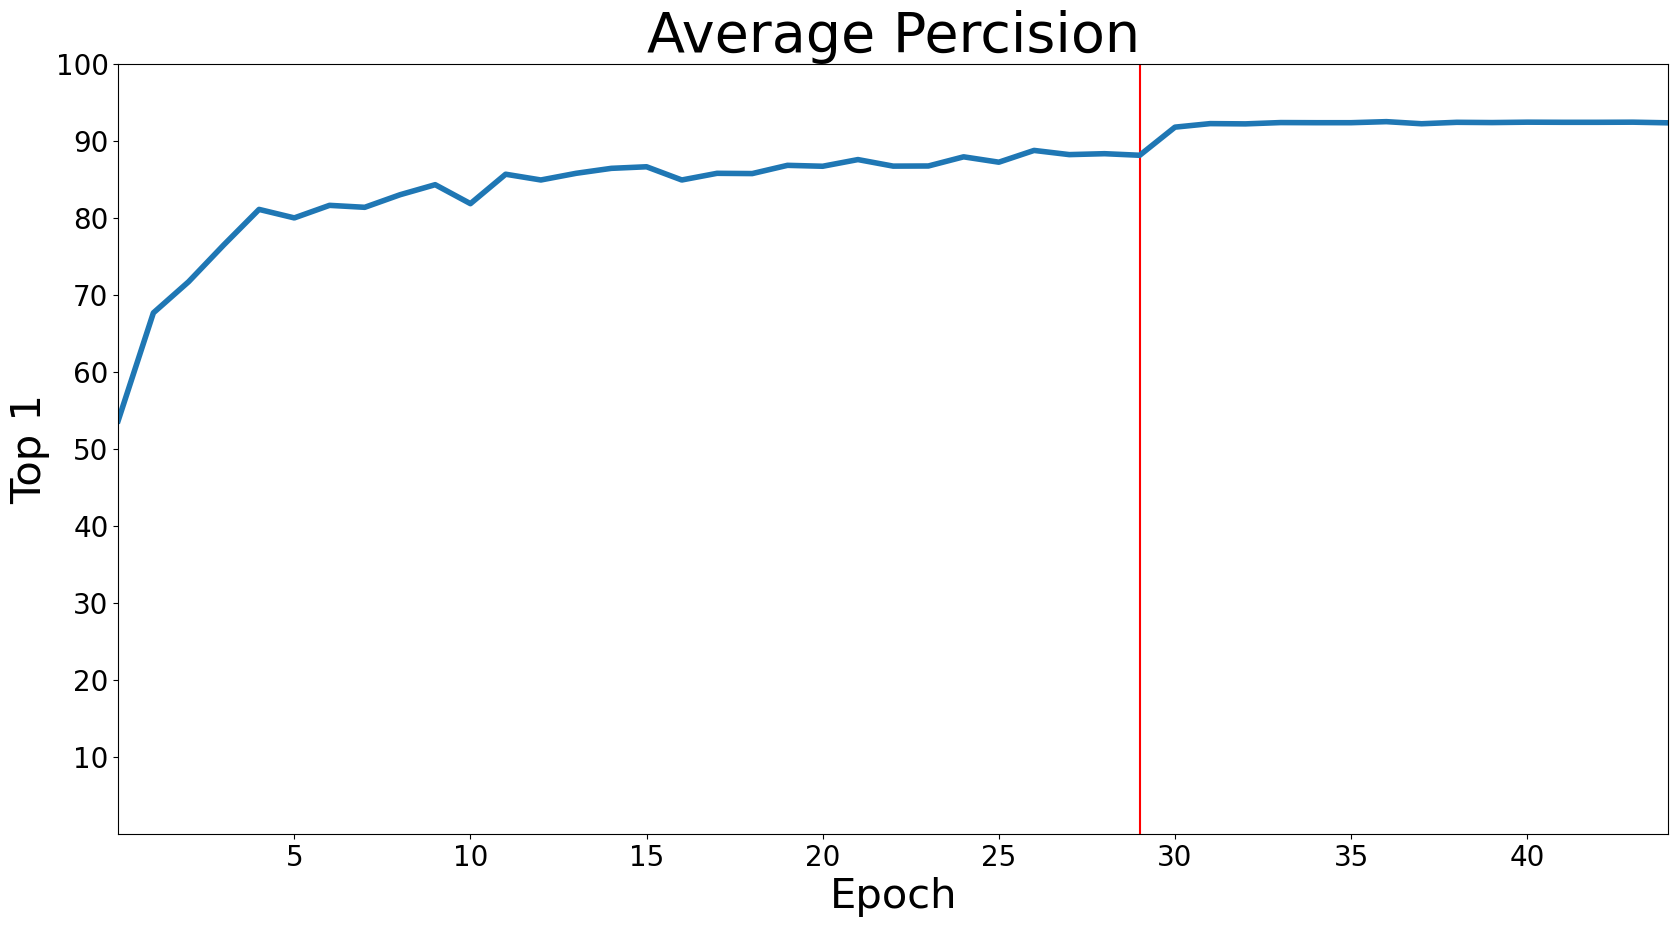

In [39]:
xticks_size = 20
yticks_size = 20
ylabel_size = 30
xlabel_size = 30 
title_size = 40
linewidth = 4

xticks = [5,10,15,20,25,30,35,40,45]


plt.figure(figsize=(20,10))

x = [i for i in range(len(prec1_array_avg))]
# plt.axvline(x = 15, color = 'r', label = 'axvline - full height')
plt.axvline(x = 29, color = 'r', label = 'axvline - full height')
# plt.axvline(x = 0, color = 'r', label = 'axvline - full height')
plt.xticks(xticks,fontsize=xticks_size)
plt.yticks([10,20,30,40,50,60,70,80,90,100],fontsize=yticks_size)
plt.ylabel('Top 1', fontsize=ylabel_size)
plt.xlabel('Epoch',fontsize=xlabel_size)
plt.title('Average Percision', fontsize=title_size)

# plt.margins(0)
plt.xlim([0, max_e])
plt.ylim([0, 100])
plt.plot(x,prec1_array_avg, linewidth = linewidth)

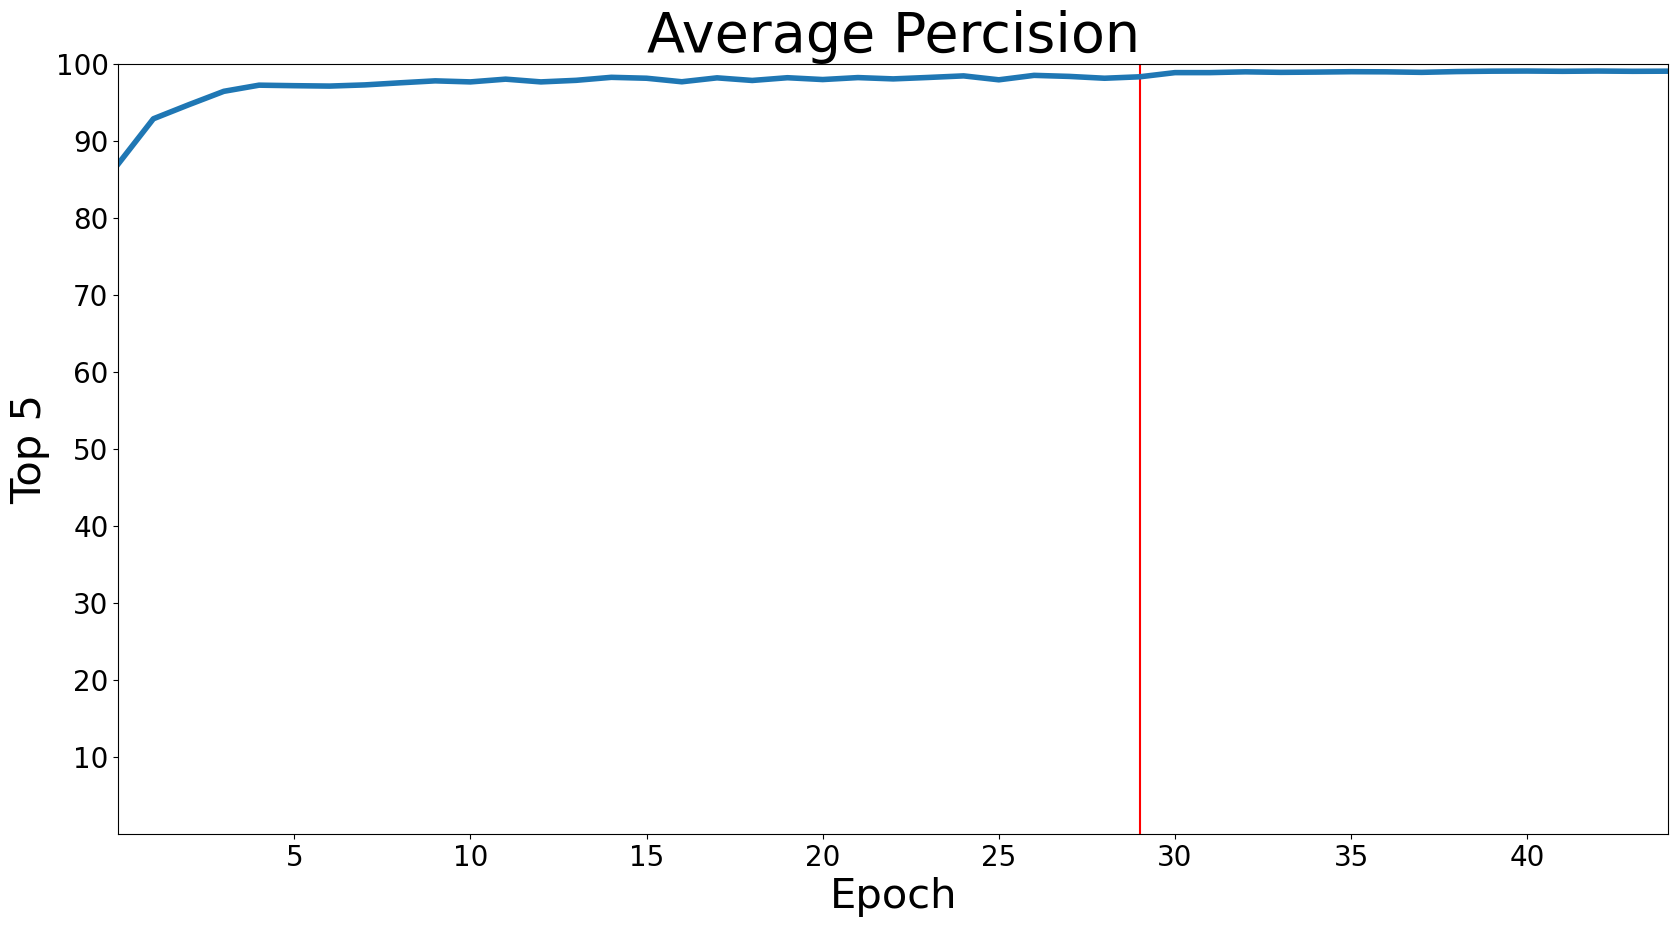

In [44]:
plt.figure(figsize=(20,10))
x = [i for i in range(len(prec5_array_avg))]
plt.axvline(x = 29, color = 'r', label = 'axvline - full height')
# plt.axvline(x = 20, color = 'r', label = 'axvline - full height')
plt.xticks(xticks,fontsize=xticks_size)
plt.yticks([10,20,30,40,50,60,70,80,90,100],fontsize=yticks_size)
plt.ylabel('Top 5', fontsize=ylabel_size)
plt.xlabel('Epoch',fontsize=xlabel_size)
plt.title('Average Percision', fontsize=title_size)

# plt.margins(0)
plt.xlim([0, max_e])
plt.ylim([0, 100])
plt.plot(x,prec5_array_avg, linewidth = linewidth)

In [30]:
x


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44]